In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2

brain-tumor-mri-dataset
- Testing
    - glioma
    - meningioma
    - notumor
    - pituitary
- Training
    - glioma
    - meningioma
    - notumor
    - pituitary


In [3]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
        self.image_files = []
        for cls in self.classes:
            img_folder = os.path.join(root_dir, cls)
            img_fnames = os.listdir(img_folder)
            self.image_files += [(cls, fname) for fname in img_fnames]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        cls, fname = self.image_files[idx]
        img_name = os.path.join(self.root_dir, cls, fname)
        image = Image.open(img_name).convert("RGB")
        label = self.classes.index(cls)
        if self.transform:
            image = self.transform(image)
        return image, label


In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_dataset = BrainTumorDataset("/kaggle/input/brain-tumor-mri-dataset/Training", transform=train_transforms)
test_dataset = BrainTumorDataset("/kaggle/input/brain-tumor-mri-dataset/Testing", transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64 * 64 * 64, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = SimpleCNN().cuda()


In [6]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")
    
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f"Accuracy on test set: {100 * correct / total}%")


Epoch: 1/10, Train Loss: 0.7200
Epoch: 2/10, Train Loss: 0.2790
Epoch: 3/10, Train Loss: 0.1642
Epoch: 4/10, Train Loss: 0.0986
Epoch: 5/10, Train Loss: 0.0615
Epoch: 6/10, Train Loss: 0.0379
Epoch: 7/10, Train Loss: 0.0499
Epoch: 8/10, Train Loss: 0.0343
Epoch: 9/10, Train Loss: 0.0221
Epoch: 10/10, Train Loss: 0.0357
Accuracy on test set: 95.72845156369183%


In [7]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
img = images[0].unsqueeze(0).cuda()  # Grab the first image and add batch dimension

In [8]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        
        # Hook the gradients
        self.hooks = []
        self.hooks.append(self.target_layer.register_forward_hook(self.save_output))
        self.hooks.append(self.target_layer.register_backward_hook(self.save_gradient))

    def save_output(self, module, input, output):
        self.output = output

    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        
        out = self.model(x)
        
        if class_idx is None:
            class_idx = np.argmax(out.cpu().data.numpy())
        
        one_hot = np.zeros((1, out.size()[-1]), dtype=np.float32)
        one_hot[0][class_idx] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True).to(x.device)
        one_hot = torch.sum(one_hot * out)
        
        one_hot.backward(retain_graph=True)

        target = self.output[0]
        gradients = self.gradients[0].cpu().data.numpy()
        weights = np.mean(gradients, axis=(1, 2))
        target = target.cpu().data.numpy()
        
        cam = np.ones(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
            
        cam = np.maximum(cam, 0)
        cam = cam / np.max(cam)
        cam = cv2.resize(cam, (256, 256))
        
        return cam


In [9]:
def visualize_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    img = img.permute(1, 2, 0).numpy()  # CxHxW -> HxWxC
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


In [10]:
target_layer = model.features[-1]
cam_extractor = GradCAM(model, target_layer)

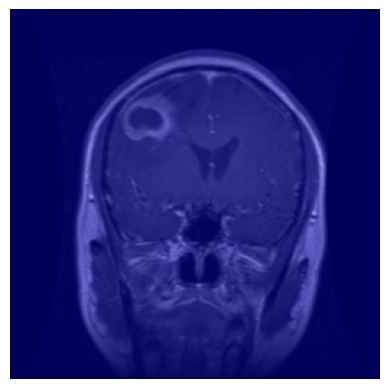

In [11]:
cam_mask = cam_extractor(img)
result = visualize_cam_on_image(images[0], cam_mask)
plt.imshow(result)
plt.axis('off')
plt.show()
